In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay


In [8]:
df = pd.read_csv("data/raw/Churn.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
def add_random_missing_values(df, min_rate=0.1, max_rate=0.3, random_state=42):
    np.random.seed(random_state)
    df_corrupted = df.copy()

    missing_rates = {}

    for col in df_corrupted.columns:
        rate = np.random.uniform(min_rate, max_rate)  # taux différent par colonne
        missing_rates[col] = rate

        mask = np.random.rand(len(df_corrupted)) < rate
        df_corrupted.loc[mask, col] = np.nan

    return df_corrupted, missing_rates

In [10]:
df_corrupted, missing_rates = add_random_missing_values(
    df,
    min_rate=0.1,
    max_rate=0.3
)

In [ ]:
for col, rate in missing_rates.items():
    print(f"{col} : {rate*100:.2f}%")

CustomerID : 17.49%
Age : 19.14%
Gender : 19.92%
Tenure : 14.48%
Usage Frequency : 12.61%
Support Calls : 24.45%
Payment Delay : 28.93%
Subscription Type : 29.55%
Contract Length : 19.18%
Total Spend : 20.98%
Last Interaction : 24.06%
Churn : 16.72%


In [ ]:
# Suppression de l'identifiant (CustomerID)
df_cleaned = df_corrupted.drop(columns=["CustomerID"])

# Identification automatique des colonnes numériques et catégorielles
num_cols = df_cleaned.select_dtypes(include=[np.number]).columns
cat_cols = df_cleaned.select_dtypes(include=["object"]).columns

# Imputation par la médiane pour les colonnes numériques
for col in num_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Imputation par le mode (valeur la plus fréquente) pour les colonnes catégorielles
for col in cat_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


print("Valeurs manquantes après nettoyage :")
print(df_cleaned.isnull().sum())
df_cleaned.head()

Valeurs manquantes après nettoyage :
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,54.0,Male,5.0,20.0,1.0,3.0,Standard,Quarterly,421.00,15.0,1.0
1,30.0,Female,33.0,21.0,10.0,27.0,Basic,Annual,649.00,19.0,1.0
2,48.0,Male,8.0,20.0,3.0,10.0,Basic,Quarterly,832.23,14.0,0.0
3,40.0,Male,30.0,5.0,1.0,13.0,Standard,Annual,649.00,12.0,0.0
4,40.0,Female,26.0,2.0,4.0,23.0,Standard,Monthly,811.00,14.0,1.0


In [ ]:
# Encodage des variables catégorielles (ex: Gender, Subscription Type)
df_final = pd.get_dummies(df_cleaned, drop_first=True)

X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

# Séparation 80% Entraînement / 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Données d'entraînement : {X_train.shape[0]} lignes")
print(f"Données de test : {X_test.shape[0]} lignes")

Données d'entraînement : 404165 lignes
Données de test : 101042 lignes


=== 5. RANDOM FOREST ===
Accuracy : 83.93%
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80     37496
         1.0       0.90      0.83      0.87     63546

    accuracy                           0.84    101042
   macro avg       0.83      0.84      0.83    101042
weighted avg       0.85      0.84      0.84    101042



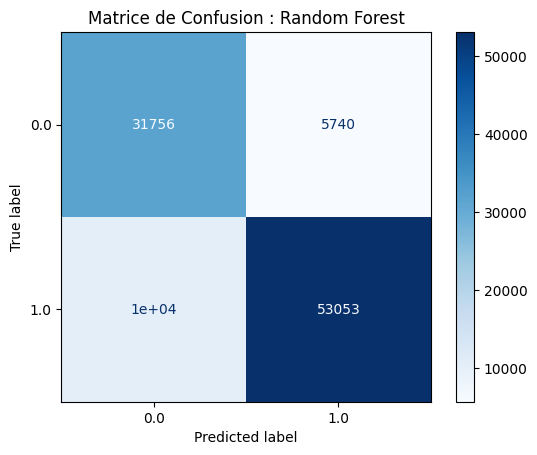

In [20]:
print("=== 5. RANDOM FOREST ===")
# Entraînement
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction
y_pred_rf = rf_model.predict(X_test)

# Évaluation Chiffrée
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.2%}")
print(classification_report(y_test, y_pred_rf))

# Matrice de Confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap='Blues')
plt.title("Matrice de Confusion : Random Forest")
plt.show()

=== 7. XGBOOST ===
Accuracy : 84.32%
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80     37496
         1.0       0.91      0.83      0.87     63546

    accuracy                           0.84    101042
   macro avg       0.83      0.85      0.84    101042
weighted avg       0.85      0.84      0.85    101042



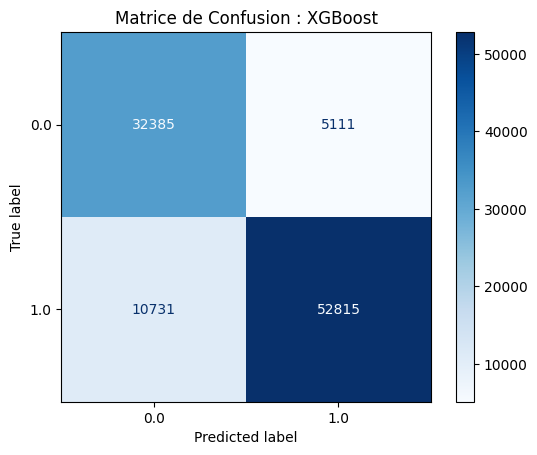

In [21]:
from xgboost import XGBClassifier

print("=== 7. XGBOOST ===")
# Initialisation
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Entraînement
xgb_model.fit(X_train, y_train)

# Prédiction
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation Chiffrée
print(f"Accuracy : {accuracy_score(y_test, y_pred_xgb):.2%}")
print(classification_report(y_test, y_pred_xgb))

# Matrice de Confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, cmap='Blues')
plt.title("Matrice de Confusion : XGBoost")
plt.show()